<a href="https://colab.research.google.com/github/Khaled-Mohammed-Abdelgaber/PPG_Clustering/blob/main/LDA%20and%20Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# importing required library

In [38]:
#to read csv files
import pandas as pd 

#to manipulate data
import numpy as np

#for ploting
import matplotlib.pyplot as plt
import seaborn as sns

#for LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#for Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#for auto-encoder
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model



# Reading Data

In [28]:
ppg_one_beat = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_PPG_beats_P2P_Aug_2022.csv",
                           names = np.arange(120))
ppg_10_beats = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_PPG_signals_10_beats_Aug_2022.csv",
                           names = np.arange(1024))
id = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_Subj_ID_beats_P2P_Aug_2022.csv",names = ["ID"])
sys_df = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_SYS_BP_beats_P2P_Aug_2022.csv",
                     names = ["sys"])
dia_df = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/p2p_beats/part_1_Dia_BP_beats_P2P_Aug_2022.csv",
                     names = ["dia"])

In [29]:
df_info = pd.DataFrame()
 
df_info["dia"]  = dia_df
df_info["sys"]  = sys_df
df_info["ID"] = id

In [30]:
df_info

,dia,sys,ID
0,66.526,123.040,1
1,65.598,120.990,1
2,66.135,119.570,1
3,66.135,122.350,1
4,67.503,122.750,1
...,...,...,...
154535,58.357,88.240,3000
154536,58.983,88.240,3000
154537,58.670,86.988,3000
154538,58.044,88.866,3000


# prepare for LDA

In [5]:
X = ppg_one_beat.values

In [6]:
y = df_info["sys"].values

In [7]:
# we will divide data to classes for every 10 steps of systolic
for i in range(len(y)):
  if y[i] < 80:
    y[i] = 0
  elif y[i] < 90:
    y[i] = 1
  elif y[i] < 100:
    y[i] = 2
  elif y[i] < 110:
    y[i] = 3
  elif y[i] < 120:
    y[i] = 4 
  elif y[i] < 130:
    y[i] = 5
  elif y[i] < 140:
    y[i] = 6
  elif y[i] < 150:
    y[i] = 7
  elif y[i] < 160:
    y[i] = 8
  elif y[i] < 170:
    y[i] = 9
  elif y[i] < 180:
    y[i] = 10
  elif y[i] < 190:
    y[i] = 11
  else:
    y[i] = 12


In [8]:
y

array([5., 5., 4., ..., 1., 1., 1.])

# LDA

In [10]:
lda = LinearDiscriminantAnalysis(n_components=12)
X_lda_comp = lda.fit(X, y).transform(X)

In [11]:
lda.explained_variance_ratio_

array([0.51752546, 0.16698827, 0.1229704 , 0.06028748, 0.05000757,
       0.02965918, 0.01789165, 0.01304061, 0.00952329, 0.00719488,
       0.00278347, 0.00212774])

In [13]:
X_lda_comp.shape #number of LDA compontents equal to number of y classes [12]

(154540, 12)

# Determine the best number of clusters

Text(0.5, 1.0, '‘Silhouette analysis For Optimal k’')

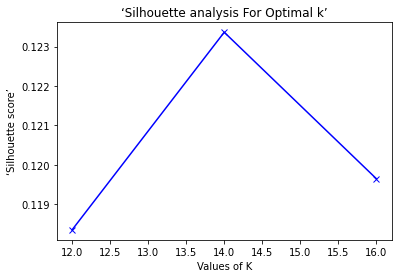

In [18]:
range_n_clusters = [ 12,14,16]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X_lda_comp)
  cluster_labels = kmeans.labels_
  
  # silhouette score
  silhouette_avg.append(silhouette_score(X_lda_comp, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel('Values of K') 
plt.ylabel("‘Silhouette score’") 
plt.title("‘Silhouette analysis For Optimal k’")

# K-means clustering

In [19]:
# initialise kmeans
kmeans = KMeans(n_clusters=14)
kmeans.fit(X_lda_comp)
LDA_cluster_labels = kmeans.labels_

In [20]:
LDA_cluster_labels

array([ 1,  1,  1, ..., 12, 12, 12], dtype=int32)

In [31]:
df_info["LDA_cluster_labels"] = LDA_cluster_labels

In [32]:
df_info

,dia,sys,ID,LDA_cluster_labels
0,66.526,123.040,1,1
1,65.598,120.990,1,1
2,66.135,119.570,1,1
3,66.135,122.350,1,1
4,67.503,122.750,1,1
...,...,...,...,...
154535,58.357,88.240,3000,12
154536,58.983,88.240,3000,12
154537,58.670,86.988,3000,12
154538,58.044,88.866,3000,12


# ploting results of LDA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

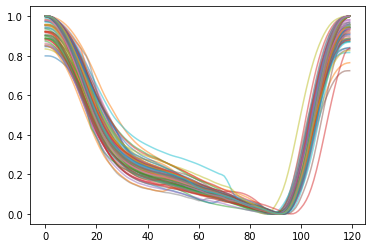

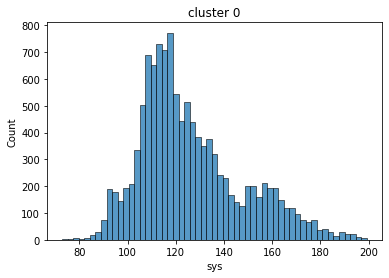

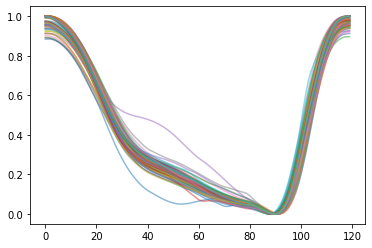

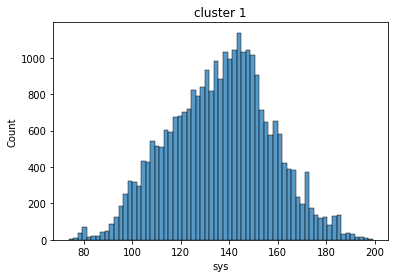

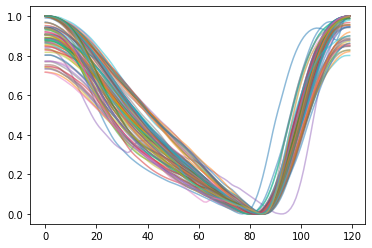

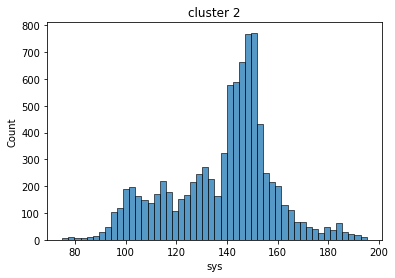

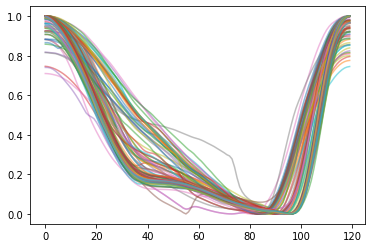

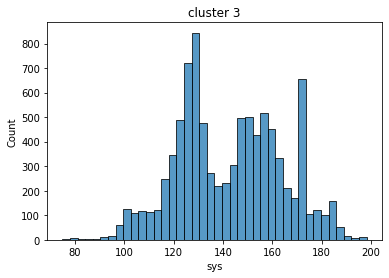

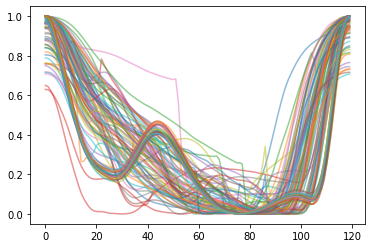

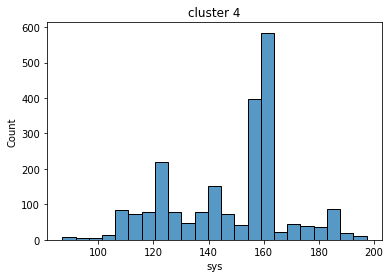

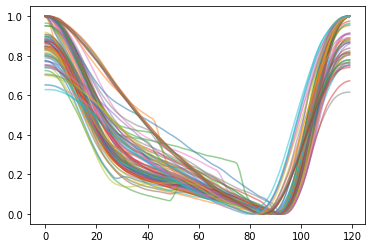

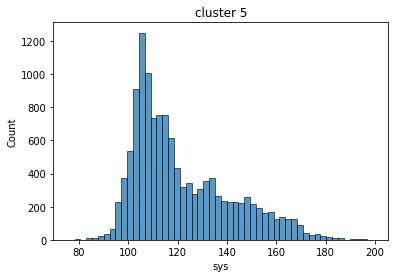

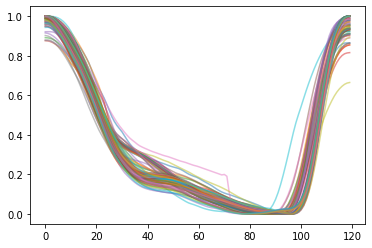

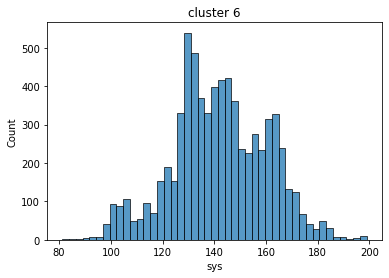

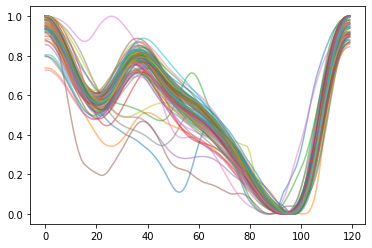

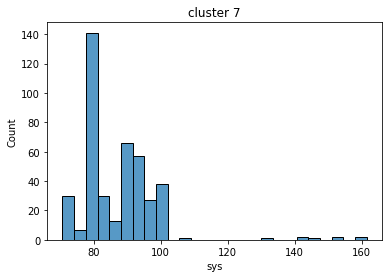

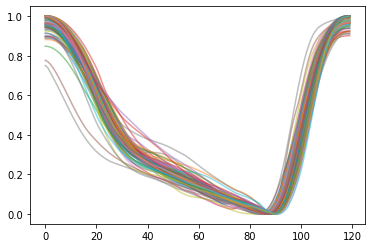

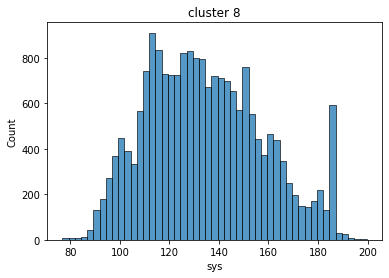

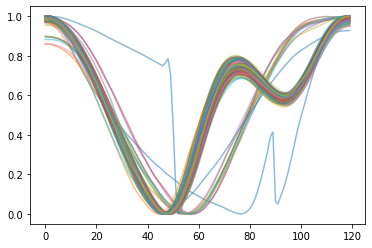

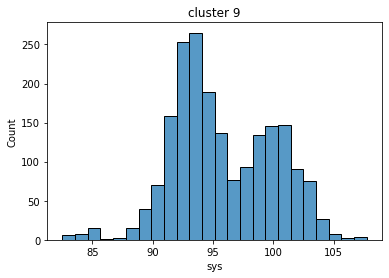

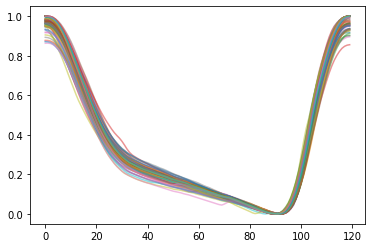

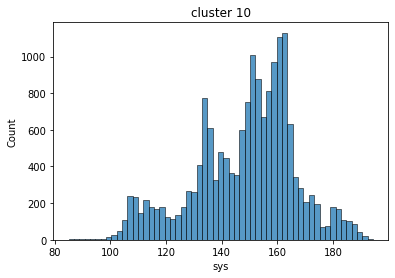

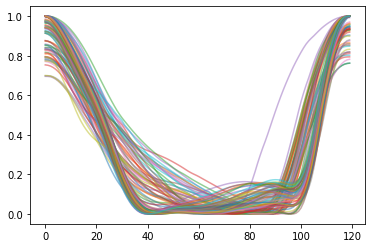

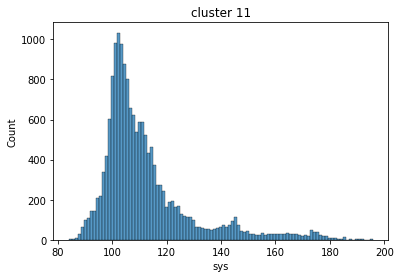

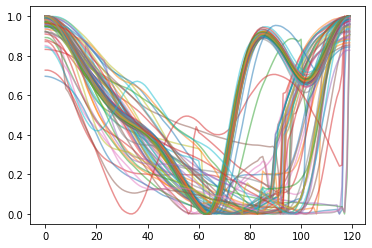

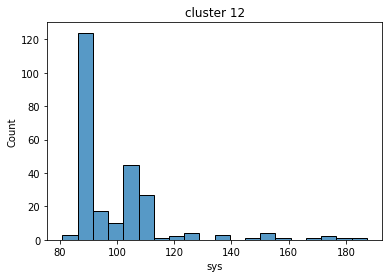

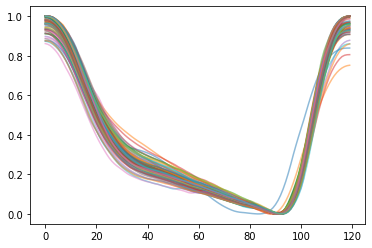

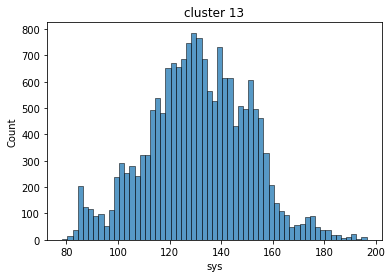

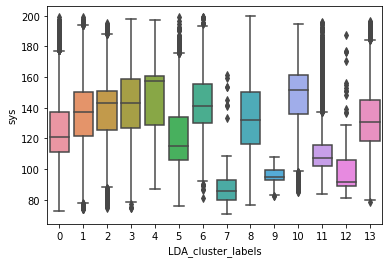

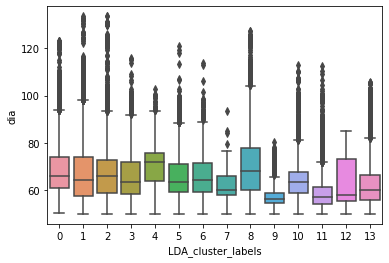

In [33]:
for i in range(14):
  plt.figure();
  plt.plot(ppg_one_beat[LDA_cluster_labels == i].values[:100].T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x =  df_info["sys"][df_info ["LDA_cluster_labels"] == i]  )

plt.figure();
sns.boxplot(x = "LDA_cluster_labels",y="sys",data = df_info)
plt.figure();
sns.boxplot(x = "LDA_cluster_labels",y="dia",data = df_info)

# AutoEncoder

# splitting data to test and validation
75% train and 25% test

In [34]:
X.shape[0]*0.75

115905.0

In [35]:
X_train = X[:115905,:]
X_test = X[115905:,:]

In [36]:
X_train.shape

(115905, 120)

# Architecture

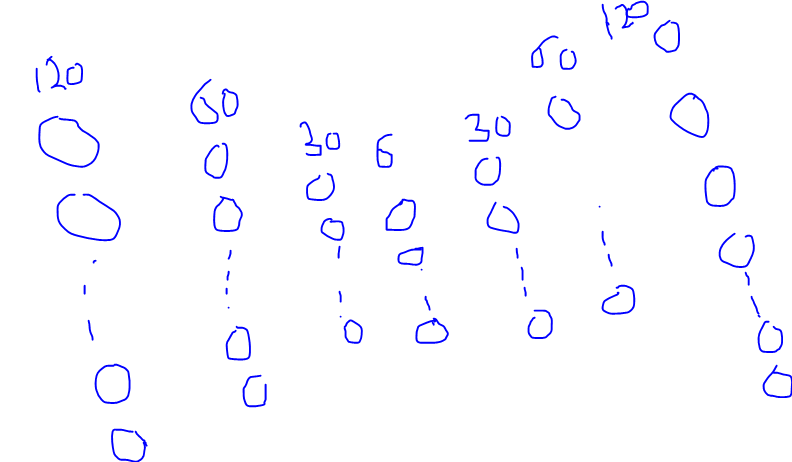

In [39]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs/2)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 3
encoder= Dense(round(float(n_inputs) / 4))(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 20)
bottleneck = Dense(n_bottleneck)(encoder)

# define decoder, level 1
decoder = Dense(round(float(n_inputs) / 4.0))(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs/2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 3
decoder = Dense(n_inputs)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

In [40]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense (Dense)               (None, 120)               14520     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 batch_normalization_1 (Batc  (None, 60)               240       
 hNormalization)                                             

# Training

In [42]:
history = model.fit(X_train, X_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_test,X_test))


Epoch 1/50
7245/7245 - 21s - loss: 0.0043 - val_loss: 0.0019 - 21s/epoch - 3ms/step
Epoch 2/50
7245/7245 - 25s - loss: 0.0015 - val_loss: 0.0012 - 25s/epoch - 3ms/step
Epoch 3/50
7245/7245 - 19s - loss: 0.0012 - val_loss: 0.0012 - 19s/epoch - 3ms/step
Epoch 4/50
7245/7245 - 17s - loss: 9.9907e-04 - val_loss: 7.4880e-04 - 17s/epoch - 2ms/step
Epoch 5/50
7245/7245 - 18s - loss: 8.7744e-04 - val_loss: 6.7102e-04 - 18s/epoch - 2ms/step
Epoch 6/50
7245/7245 - 17s - loss: 8.0101e-04 - val_loss: 6.9485e-04 - 17s/epoch - 2ms/step
Epoch 7/50
7245/7245 - 17s - loss: 7.4421e-04 - val_loss: 6.2526e-04 - 17s/epoch - 2ms/step
Epoch 8/50
7245/7245 - 17s - loss: 6.9304e-04 - val_loss: 5.5499e-04 - 17s/epoch - 2ms/step
Epoch 9/50
7245/7245 - 17s - loss: 6.6044e-04 - val_loss: 5.2002e-04 - 17s/epoch - 2ms/step
Epoch 10/50
7245/7245 - 18s - loss: 6.4195e-04 - val_loss: 6.3432e-04 - 18s/epoch - 2ms/step
Epoch 11/50
7245/7245 - 18s - loss: 6.1303e-04 - val_loss: 5.8252e-04 - 18s/epoch - 2ms/step
Epoch 12/5

# Saving model in google drive

In [43]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('/content/gdrive/MyDrive/data/encoder150000beat.h5')

In [44]:
encoder = load_model('encoder.h5')
encoder.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense_38 (Dense)            (None, 120)               14520     
                                                                 
 batch_normalization_28 (Bat  (None, 120)              480       
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 120)               0         
                                                                 
 dense_39 (Dense)            (None, 60)                7260      
                                                                 
 batch_normalization_29 (Bat  (None, 60)               240       
 chNormalization)                                         

# convert data to encoded data using previous saved model

In [45]:
X_encode = encoder.predict(X)

Text(0.5, 1.0, '‘Silhouette analysis For Optimal k’')

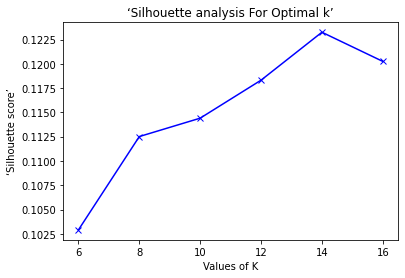

In [46]:
# check best K for clustering 
range_n_clusters = [ 6,8,10,12,14,16]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X_lda_comp)
  cluster_labels = kmeans.labels_
  
  # silhouette score
  silhouette_avg.append(silhouette_score(X_lda_comp, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel('Values of K') 
plt.ylabel("‘Silhouette score’") 
plt.title("‘Silhouette analysis For Optimal k’")

In [47]:
# initialise kmeans
kmeans = KMeans(n_clusters=14)
kmeans.fit(X_encode)
encoder_cluster_labels = kmeans.labels_

In [48]:
df_info ["encoder_cluster_labels"] = encoder_cluster_labels

In [49]:
df_info

,dia,sys,ID,LDA_cluster_labels,encoder_cluster_labels
0,66.526,123.040,1,1,3
1,65.598,120.990,1,1,3
2,66.135,119.570,1,1,3
3,66.135,122.350,1,1,3
4,67.503,122.750,1,1,3
...,...,...,...,...,...
154535,58.357,88.240,3000,12,10
154536,58.983,88.240,3000,12,10
154537,58.670,86.988,3000,12,10
154538,58.044,88.866,3000,12,10


# ploting autoencoder clustering result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

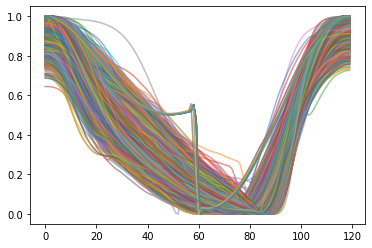

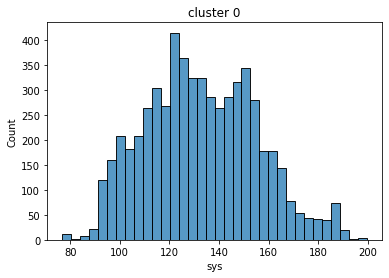

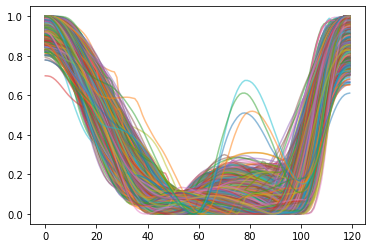

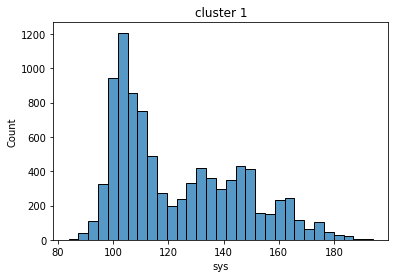

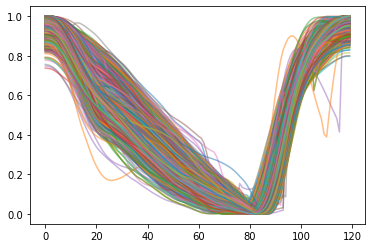

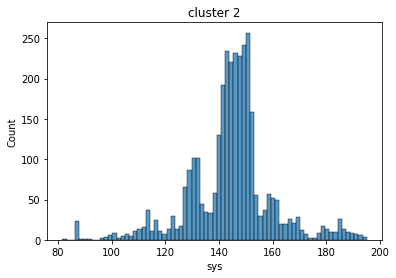

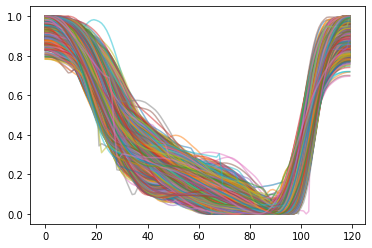

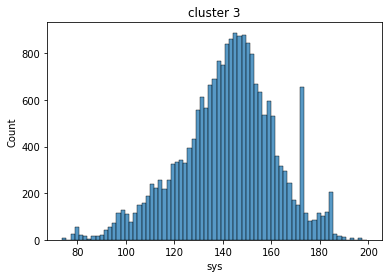

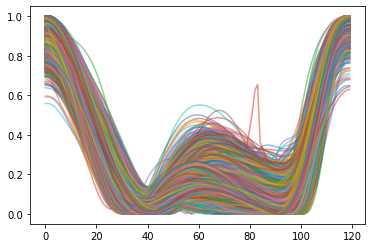

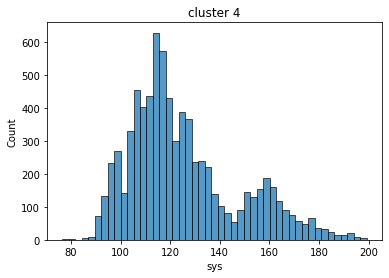

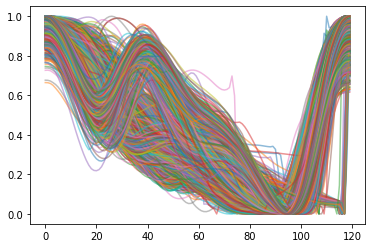

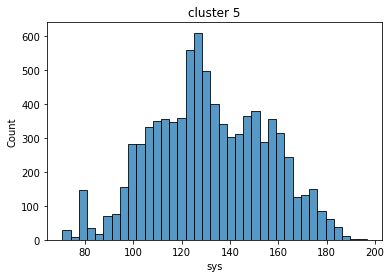

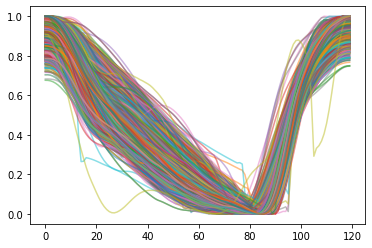

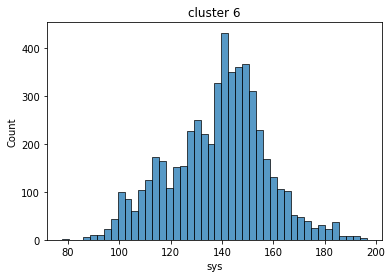

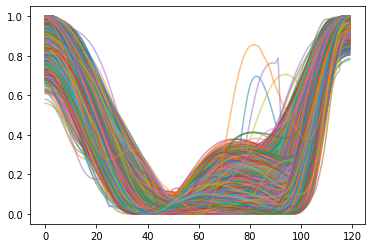

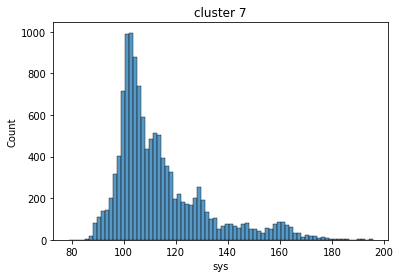

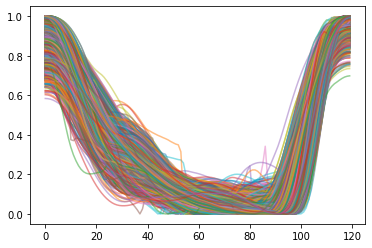

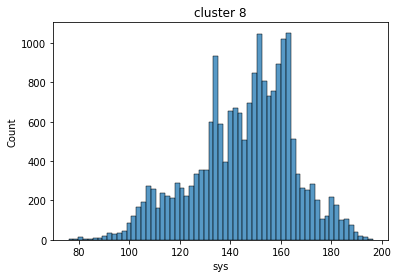

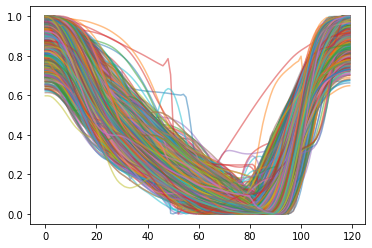

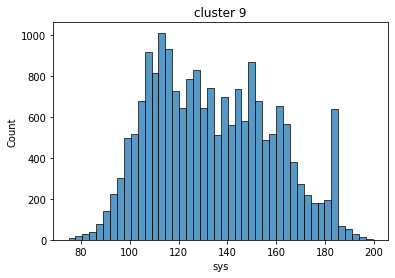

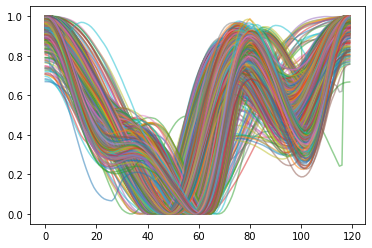

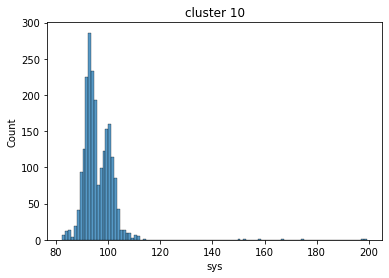

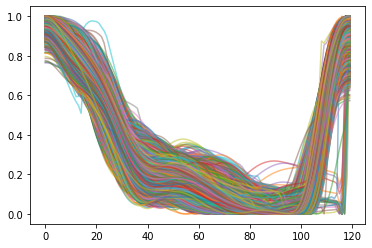

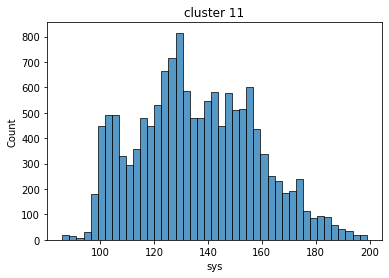

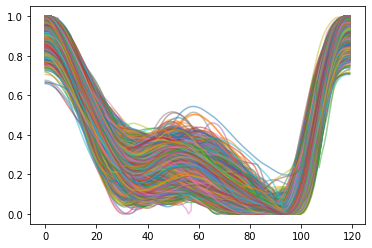

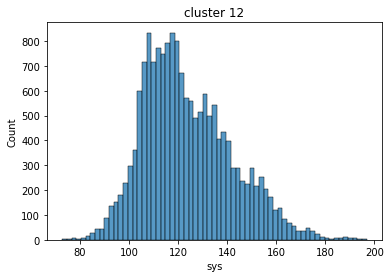

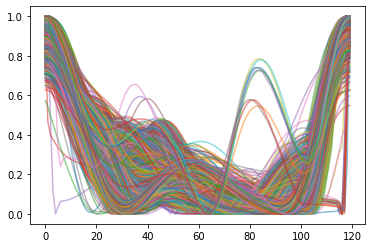

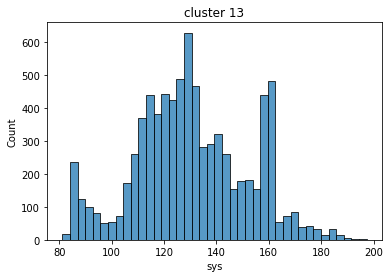

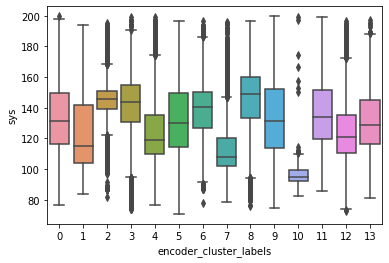

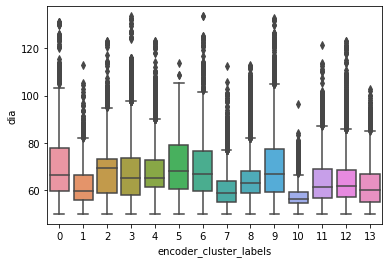

In [50]:
for i in range(14):
  plt.figure();
  plt.plot(ppg_one_beat[encoder_cluster_labels == i].values.T,alpha = 0.5);
  
  plt.figure();
  plt.title("cluster "+str(i))
  sns.histplot(x = df_info["sys"][df_info ["encoder_cluster_labels"] == i]  )

plt.figure();
sns.boxplot(x = "encoder_cluster_labels",y="sys",data = df_info)
plt.figure();
sns.boxplot(x = "encoder_cluster_labels",y="dia",data = df_info)